In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [21]:
# Load npz file containing image arrays
x_npz = np.load("/volumes/data/chest_xray/numpy_array/x_images_arrays.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load("/volumes/data/chest_xray/numpy_array/y_infiltration_labels.npz")
y = y_npz['arr_0']

In [22]:
# Split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

X_train = X_train * 1./255.  #Getting data in 0-1 range
X_val = X_val * 1./255.

print(np.array(X_train).shape)
print(np.array(X_val).shape)
print('Number of images of no disease found in training: ', sum(y_train == 1))
print('Number of images of disease found in training: ', sum(y_train == 0))

(4484, 224, 224, 3)
(1122, 224, 224, 3)
Number of images of no disease found in training:  2435
Number of images of disease found in training:  2049


In [4]:
img_width, img_height = 224, 224 # to match densenet dimensions.
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 50
batch_size = 16

In [17]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
import densenet

# 'tf' dim-ordering
image_dim = (224, 224, 3)

model = densenet.DenseNetImageNet121(input_shape=image_dim, classes =1, include_top = False, activation = 'sigmoid')
x = model.layers[-1].output
x = Dense(1, activation='sigmoid', name='predictions')(x)
model = Model(inputs = model.input, outputs = x, name='densenet')

Weights for the model were loaded successfully


In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_721 (Conv2D)              (None, 112, 112, 64)  9408        input_11[0][0]                   
____________________________________________________________________________________________________
batch_normalization_727 (BatchNo (None, 112, 112, 64)  256         conv2d_721[0][0]                 
____________________________________________________________________________________________________
activation_727 (Activation)      (None, 112, 112, 64)  0           batch_normalization_727[0][0]    
___________________________________________________________________________________________

____________________________________________________________________________________________________
activation_828 (Activation)      (None, 7, 7, 128)     0           batch_normalization_828[0][0]    
____________________________________________________________________________________________________
conv2d_822 (Conv2D)              (None, 7, 7, 32)      36864       activation_828[0][0]             
____________________________________________________________________________________________________
concatenate_397 (Concatenate)    (None, 7, 7, 736)     0           concatenate_396[0][0]            
                                                                   conv2d_822[0][0]                 
____________________________________________________________________________________________________
batch_normalization_829 (BatchNo (None, 7, 7, 736)     2944        concatenate_397[0][0]            
___________________________________________________________________________________________

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [24]:
model_checkpoint = ModelCheckpoint('densenet_based_1.h5', monitor='val_loss', save_best_only=True)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    shuffle = True
)

model.load_weights('densenet_based_1.h5')
model.save('densenet_based_model_1.h5')

Epoch 1/20
280/280 [==============================] - 330s - loss: 1.0159 - acc: 0.5944 - val_loss: 1.4751 - val_acc: 0.5571
Epoch 2/20
280/280 [==============================] - 216s - loss: 0.9429 - acc: 0.6388 - val_loss: 1.6560 - val_acc: 0.5009
Epoch 3/20
280/280 [==============================] - 218s - loss: 0.8893 - acc: 0.6424 - val_loss: 1.0666 - val_acc: 0.5353
Epoch 4/20
280/280 [==============================] - 216s - loss: 0.8475 - acc: 0.6411 - val_loss: 1.1330 - val_acc: 0.5036
Epoch 5/20
280/280 [==============================] - 218s - loss: 0.8067 - acc: 0.6547 - val_loss: 0.8616 - val_acc: 0.6600
Epoch 6/20
280/280 [==============================] - 218s - loss: 0.7789 - acc: 0.6549 - val_loss: 0.8337 - val_acc: 0.5009
Epoch 7/20
280/280 [==============================] - 216s - loss: 0.7487 - acc: 0.6583 - val_loss: 0.8819 - val_acc: 0.6320
Epoch 8/20
280/280 [==============================] - 216s - loss: 0.7229 - acc: 0.6607 - val_loss: 1.8850 - val_acc: 0.4593


In [27]:
def plot_history(history):
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title(' model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['acc']), plt.plot(history.history['val_acc'])
    plt.title(' model accuracy'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
    plt.show()

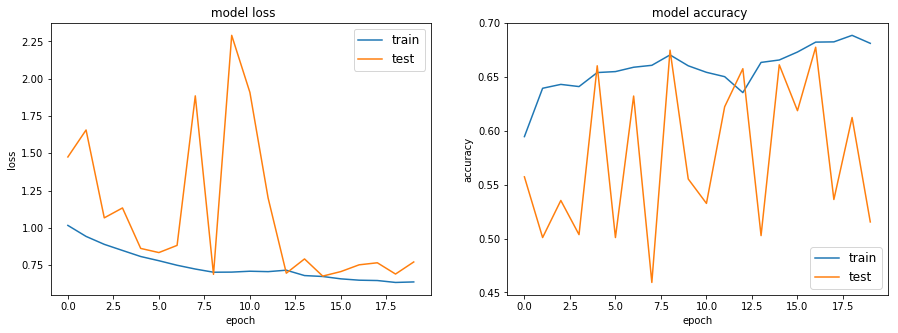

In [28]:
plot_history(history)

In [31]:
y_pred = model.predict(X_val)

In [32]:
from sklearn import metrics

def cutoff_youdens_j(fpr,tpr,thresholds): # Finding optimum threshold for binary classification
    j_scores = tpr-fpr                    # desired threshold has high tpr and low fpr 
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

fpr,tpr,thresholds = metrics.roc_curve(y_val, y_pred)


In [33]:
opti_thresh = cutoff_youdens_j(fpr,tpr,thresholds)

In [37]:
a = y_pred
a[a > opti_thresh] = 1
a[a <= opti_thresh] = 0

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy on validation: '+'\n', accuracy_score(y_val, a))
print('Confusion Matrix: '+'\n', confusion_matrix(y_val, a))

Accuracy on validation: 
 0.667557932264
Confusion Matrix: 
 [[352 161]
 [212 397]]


### Attenmaps

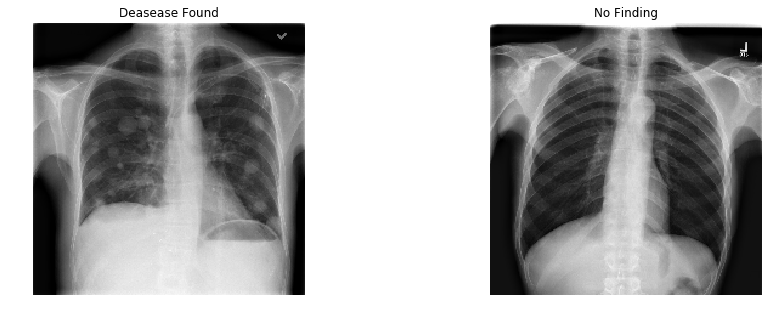

In [39]:
img1 = X_val[0,...]
img2 = X_val[1,...]

plt.subplot(121)
plt.imshow(img1), plt.title('Deasease Found'), plt.axis('off')

plt.subplot(122)
plt.imshow(img2), plt.title('No Finding'), plt.axis('off');

In [44]:
from vis.utils import utils
from keras import activations
import matplotlib.cm as cm
from vis.visualization import visualize_cam, visualize_saliency, overlay


# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 'preds')
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

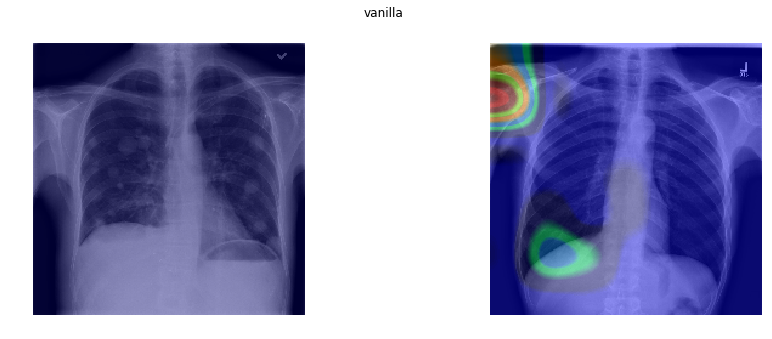

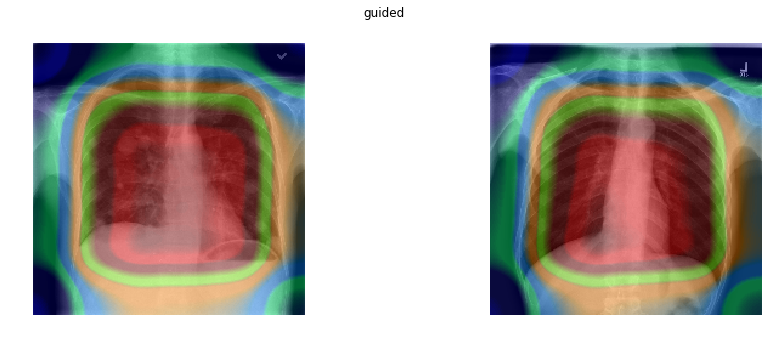

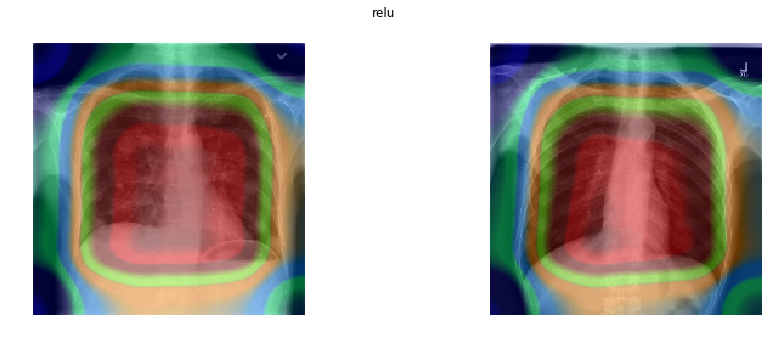

In [45]:
for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(model, layer_idx, filter_indices=[0], 
                              seed_input=img, backprop_modifier=modifier, )        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)*255)[:, : , :, 0]
        ax[i].imshow(overlay(jet_heatmap, img, alpha = 0.4)), ax[i].set_axis_off()